In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
case = 'g.e11.G.T62_t12.eco.006'
path = '/glade/scratch/mclong/hi-res-eco/' + case +'/ocn/hist/'  # + case +'.pop.h.0005-12-16.nc'
variables=['spC','diatC','SSH','PD','SiO3','Fe','NO3']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']
n_reps = 45 #for smoothing
ssh_anom_thres=5

regions=['sigma24to24.25','sigma24.25to24.5','sigma24.5to24.75','sigma24.75to25',
         'sigma25to25.25','sigma25.25to25.5','sigma25.5to25.75','sigma25.75to26',
         'sigma26to26.25','sigma26.25to26.5','sigma26.5to26.75','sigma26.75to27',
         'sigma27to27.25','sigma27.25to27.5','sigma27.5to27.75','sigma27.75to28']

In [3]:
files=[]
files.extend(sorted(glob(f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist/{case}.pop.h.0005-01-05.nc')))
ds = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                   drop_variables=["transport_components", "transport_regions"], decode_times=True)


### correlation matrix for each var, for each basin

In [4]:
ds_sigmaregs_correlations=dict()

ds_r_vals=xr.Dataset()
ds_m_vals=xr.Dataset()
ds_p_vals=xr.Dataset()

variables=['spC','diatC','SSH','SiO3','Fe','NO3'] #all variables except for PD

for var in variables:


    ds_r_vals[var]=xr.DataArray(np.full((len(regions),12),99.,dtype=float),dims=('sigma_reg','month'))

    ds_p_vals[var]=xr.DataArray(np.full((len(regions),12),99.,dtype=float),dims=('sigma_reg','month'))

    ds_m_vals[var]=xr.DataArray(np.full((len(regions),12),99.,dtype=float),dims=('sigma_reg','month'))


In [5]:
%%time
# basin=basin_names[0]

# print('doing basin', basin)

r_for_var = np.empty([len(regions),12])
p_for_var = np.empty([len(regions),12])

for month in np.arange(1,13,1):
    
    print('doing month', month)
    
    #first get the data for just this month
    files = []
    mo2="{:02d}".format(month)
    files.extend(sorted(glob(f'/glade/scratch/mclong/hi-res-eco/{case}/ocn/hist/{case}.pop.h.0005-{mo2}-??.nc')))
    ds = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    
    ### make all the vars in the dataset 2-D vars (with a time dim)
    ds['spC']=ds.spC.isel(z_t_150m=0).squeeze()
    ds['diatC']=ds.diatC.isel(z_t_150m=0).squeeze()
    ds['sigma_surf']=ds.PD.isel(z_t=0).squeeze() * 1000. - 1000.
    ds['Fe']=ds.Fe.isel(z_t=0).squeeze()
    ds['NO3']=ds.NO3.isel(z_t=0).squeeze()
    ds['SiO3']=ds.SiO3.isel(z_t=0).squeeze()

    # #let's drop PD and PFT Chl since we don't really need these right now
    ds = ds.drop(['PD']).squeeze()

    # #redefine variable list with only 2-D vars 
    variables=['spC','diatC','SSH','SiO3','Fe','NO3','sigma_surf']
    
    #define dimensions
    tlen=len(ds.time) #number of 5 day output means
    ylen=len(ds.nlat)
    xlen=len(ds.nlon)
    lons=ds.TLONG
    lats=ds.TLAT
    
    #now let's creat the anomaly dataset
    ds_anoms=xr.Dataset()

    for v in variables:
        print('variable', v)
        anoms=np.empty([tlen,ylen,xlen])
        for t in np.arange(0,tlen,1):
            print('timestep: ',t)
            tmp = ds[v].isel(time=t)
            tmp = mpcalc.smooth_n_point(tmp, 9, n_reps)
            tmp = xr.DataArray(tmp,dims=('nlat','nlon'))
            anoms[t,:,:] = ds[v].isel(time=t).values - tmp.values
        anoms = xr.DataArray(anoms, dims=('time','nlat','nlon'))
        print('writing out',v)
        ds_anoms[v]=anoms
    
    ###make ones array on which to base sigma masks
    ones = np.full((ylen, xlen), 1, dtype=int)
    ones = xr.DataArray(ones, dims=('nlat','nlon'))
    

    #create sigma masks in a dataset
    masks=xr.Dataset()
    masks['sigma24to24.25']=ones.where(ds.TLAT<0).where(ds.sigma_surf<24.25).where(ds.sigma_surf>=24).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma24.25to24.5']=ones.where(ds.TLAT<0).where(ds.sigma_surf<24.5).where(ds.sigma_surf>=24.25).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma24.5to24.75']=ones.where(ds.TLAT<0).where(ds.sigma_surf<24.75).where(ds.sigma_surf>=24.5).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma24.75to25']=ones.where(ds.TLAT<0).where(ds.sigma_surf<25).where(ds.sigma_surf>=24.75).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    
    masks['sigma25to25.25']=ones.where(ds.TLAT<0).where(ds.sigma_surf<25.25).where(ds.sigma_surf>=25).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma25.25to25.5']=ones.where(ds.TLAT<0).where(ds.sigma_surf<25.5).where(ds.sigma_surf>=25.25).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma25.5to25.75']=ones.where(ds.TLAT<0).where(ds.sigma_surf<25.75).where(ds.sigma_surf>=25.5).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma25.75to26']=ones.where(ds.TLAT<0).where(ds.sigma_surf<26).where(ds.sigma_surf>=25.75).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    
    masks['sigma26to26.25']=ones.where(ds.TLAT<0).where(ds.sigma_surf<26.25).where(ds.sigma_surf>=26).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma26.25to26.5']=ones.where(ds.TLAT<0).where(ds.sigma_surf<26.5).where(ds.sigma_surf>=26.25).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma26.5to26.75']=ones.where(ds.TLAT<0).where(ds.sigma_surf<26.75).where(ds.sigma_surf>=26.5).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma26.75to27']=ones.where(ds.TLAT<0).where(ds.sigma_surf<27).where(ds.sigma_surf>=26.75).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    
    masks['sigma27to27.25']=ones.where(ds.TLAT<0).where(ds.sigma_surf<27.25).where(ds.sigma_surf>=27).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma27.25to27.5']=ones.where(ds.TLAT<0).where(ds.sigma_surf<27.5).where(ds.sigma_surf>=27.25).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma27.5to27.75']=ones.where(ds.TLAT<0).where(ds.sigma_surf<27.75).where(ds.sigma_surf>=27.5).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    masks['sigma27.75to28']=ones.where(ds.TLAT<0).where(ds.sigma_surf<28).where(ds.sigma_surf>=27.75).where(abs(ds_anoms.SSH)>ssh_anom_thres)
    
    #now let's do the correlations between SSH and each var
    y_vars=['spC','diatC','SSH','SiO3','Fe','NO3']

    x = 0
    for var in y_vars:
        y = 0
        
        r_values=np.empty([len(regions)])
        p_values=np.empty([len(regions)])
        m_values=np.empty([len(regions)])
        
        for reg in regions:

            print('region: ', reg, 'var: ', var)

            #define vars
            y_vals = ds_anoms[var]
            ssh_vals = ds_anoms['SSH']
            #mask data
            y_vals = y_vals.where(masks[reg]==1) 
            ssh_vals = ssh_vals.where(masks[reg]==1)
            #make into numpy array
            y_vals = y_vals.values
            ssh_vals = ssh_vals.values

            mask = ~np.isnan(ssh_vals) & ~np.isnan(y_vals) & ~np.isinf(y_vals) & ~np.isinf(ssh_vals)
            y_vals = y_vals[mask]
            ssh_vals = ssh_vals[mask]

            y_vals=y_vals.flatten()
            ssh_vals=ssh_vals.flatten()
            
            if y_vals.size > 4:

                slope, intercept, r_value, p_value, std_err = stats.linregress(ssh_vals,y_vals)
                #print('y=', y, 'x=', x)
                r_values[y] = r_value
                p_values[y] = p_value
                m_values[y] = slope
                
            else:
                slope, intercept, r_value, p_value, std_err = np.nan, np.nan, np.nan, np.nan, np.nan
                r_values[y] = r_value
                p_values[y] = p_value
                m_values[y] = slope
                
            y = y +1
            
        ds_r_vals[var][:,month-1]=r_values
        ds_p_vals[var][:,month-1]=p_values
        ds_m_vals[var][:,month-1]=m_values
        
        x = x+1
        
#ds_sigmaregs_correlations['Global']=ds_r_vals

doing month 1
variable spC
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out spC
variable diatC
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out diatC
variable SSH
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out SSH
variable SiO3
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out SiO3
variable Fe
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out Fe
variable NO3
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out NO3
variable sigma_surf
timestep:  0
timestep:  1
timestep:  2
timestep:  3
timestep:  4
timestep:  5
writing out sigma_surf
region:  sigma24to24.25 var:  spC
region:  sigma24.25to24.5 var:  spC
region:  sigma24.5to24.75 var:  spC
region:  sigma24.75to25 var:  spC
region:  sigma25to25.25 var:  spC
region:  sigma25.25to25.5 var:  spC
region:  

In [6]:
ds_r_vals['sigma_reg']=[24.125,24.375,24.625,24.875,
                        25.125,25.375,25.625,25.875,
                        26.125,26.375,26.625,26.875,
                        27.125,27.375,27.625,27.875,
                       ]

In [7]:
ds_r_vals['month']=[1,2,3,4,5,6,7,8,9,10,11,12]

In [8]:
outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_rvals.nc'
ds_r_vals.to_netcdf(outfile)
outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_pvals.nc'
ds_p_vals.to_netcdf(outfile)
outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_mvals.nc'
ds_m_vals.to_netcdf(outfile)

In [9]:
########################### start here after it's already ran #################################################

In [3]:
months=[1,2,3,4,5,6,7,8,9,10,11,12]

In [5]:
outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_rvals.nc'
ds_r_vals=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_pvals.nc'
ds_p_vals=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/phytovars2_ssh_sigmareg_mvals.nc'
ds_m_vals=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/lat_ssh_means_sigmareg.nc'
ds_lat_ssh=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [9]:
ds_r_vals

<xarray.Dataset>
Dimensions:    (month: 12, sigma_reg: 16)
Coordinates:
  * sigma_reg  (sigma_reg) float64 24.12 24.38 24.62 24.88 ... 27.38 27.62 27.88
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spC        (sigma_reg, month) float64 -0.02973 -0.1637 ... -0.07863 -0.7695
    diatC      (sigma_reg, month) float64 -0.119 -0.1234 ... -0.01585 -0.6015
    SSH        (sigma_reg, month) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    SiO3       (sigma_reg, month) float64 -0.09072 -0.2268 ... -0.5929 -0.8226
    Fe         (sigma_reg, month) float64 -0.00709 -0.006648 ... -0.6093 0.4468
    NO3        (sigma_reg, month) float64 -0.1761 -0.09735 ... -0.2096 0.7696

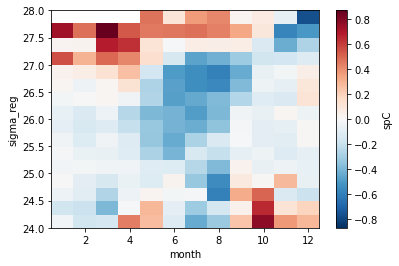

In [7]:
ds_r_vals.spC.plot()

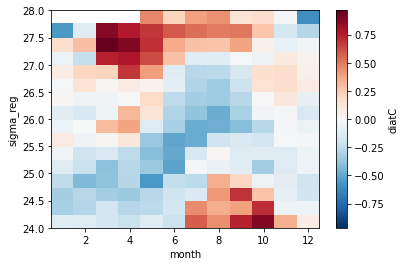

In [8]:
ds_r_vals['diatC'].plot()

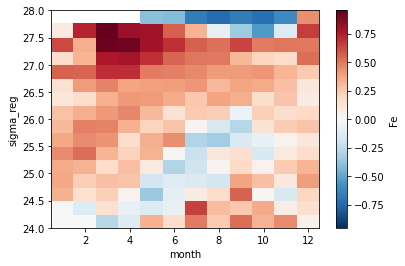

In [10]:
ds_r_vals['Fe'].plot()

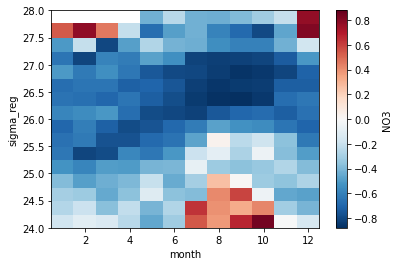

In [11]:
ds_r_vals['NO3'].plot()

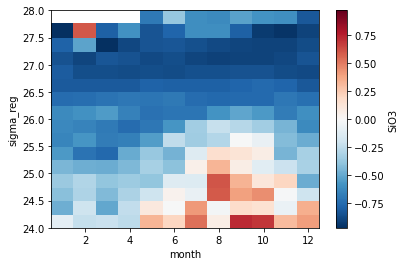

In [12]:
ds_r_vals['SiO3'].plot()

In [13]:
ds_r_vals['sigma_reg'].values

array([24.125, 24.375, 24.625, 24.875, 25.125, 25.375, 25.625, 25.875,
       26.125, 26.375, 26.625, 26.875, 27.125, 27.375, 27.625, 27.875])

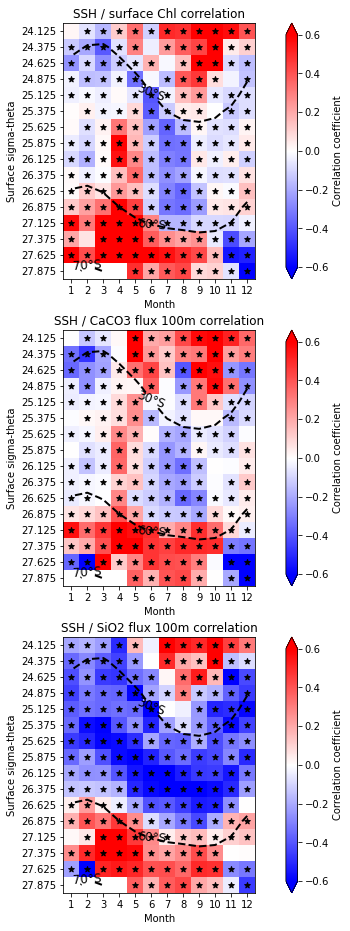

In [11]:
fig = plt.figure(figsize=(11,16))

ax = fig.add_subplot(3,1,1)

ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(ds_r_vals['totChl_surf'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.totChl_surf[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
################## add contour lines of latitude/SSH
levels=[-70.,-60.,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['70°S','60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)

ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Correlation coefficient')

ax = fig.add_subplot(3,1,2)

ax.set_title('SSH / CaCO3 flux 100m correlation')
pc=ax.imshow(ds_r_vals['CaCO3_FLUX_IN'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.CaCO3_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
################## add contour lines of latitude/SSH
levels=[-70.,-60.,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['70°S','60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)


ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Correlation coefficient')

ax = fig.add_subplot(3,1,3)

ax.set_title('SSH / SiO2 flux 100m correlation')
pc=ax.imshow(ds_r_vals['SiO2_FLUX_IN'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.SiO2_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
            
################## add contour lines of latitude/SSH
levels=[-70.,-60.,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['70°S','60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)

ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Correlation coefficient');

fig.savefig('/glade/u/home/kristenk/besome/hi-res-analysis/figs/hovmoeller_corr_fluxes_chl_sigma.png', bbox_inches='tight', format='png', dpi=600);

### Chl community at surface

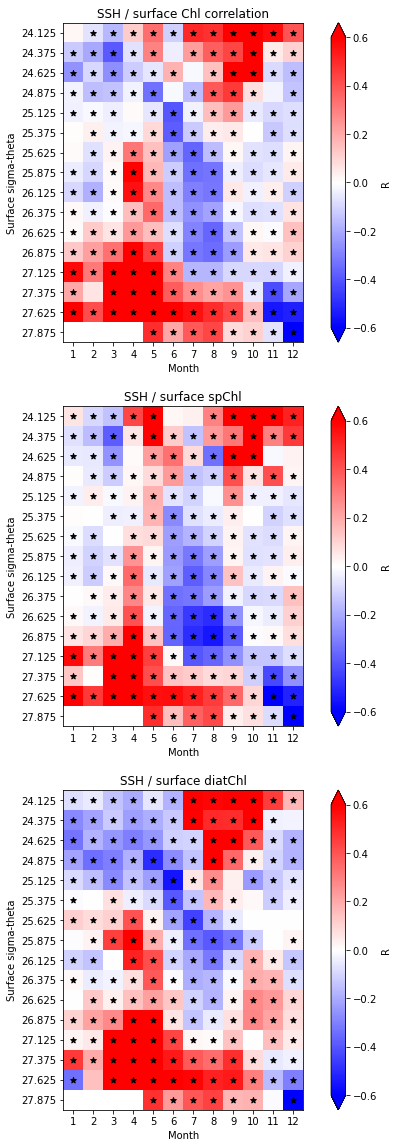

In [16]:
fig = plt.figure(figsize=(10,20))

ax = fig.add_subplot(3,1,1)

ax.set_title('SSH / surface Chl correlation')
pc=ax.imshow(ds_r_vals['totChl_surf'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.totChl_surf[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

ax = fig.add_subplot(3,1,2)

ax.set_title('SSH / surface spChl')
pc=ax.imshow(ds_r_vals['spChl'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.spChl[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

ax = fig.add_subplot(3,1,3)

ax.set_title('SSH / surface diatChl')
pc=ax.imshow(ds_r_vals['diatChl'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.diatChl[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R')

# ax = fig.add_subplot(4,1,4)

# ax.set_title('SSH / surface diazChl')
# pc=ax.imshow(ds_r_vals['diazChl'].values,cmap='bwr',vmin=-0.6,vmax=0.6)
# for i in range(len(ds_r_vals.sigma_reg)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.diazChl[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")
# ax.set_xticks(np.arange(len(ds_r_vals.month)))
# ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# # ... and label them with the respective list entries
# ax.set_xticklabels(ds_r_vals.month.values)
# ax.set_yticklabels(ds_r_vals.sigma_reg.values)
# ax.set_ylabel('SSH (cm)')
# ax.set_xlabel('Month')
# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='R');

### Slopes from regressions

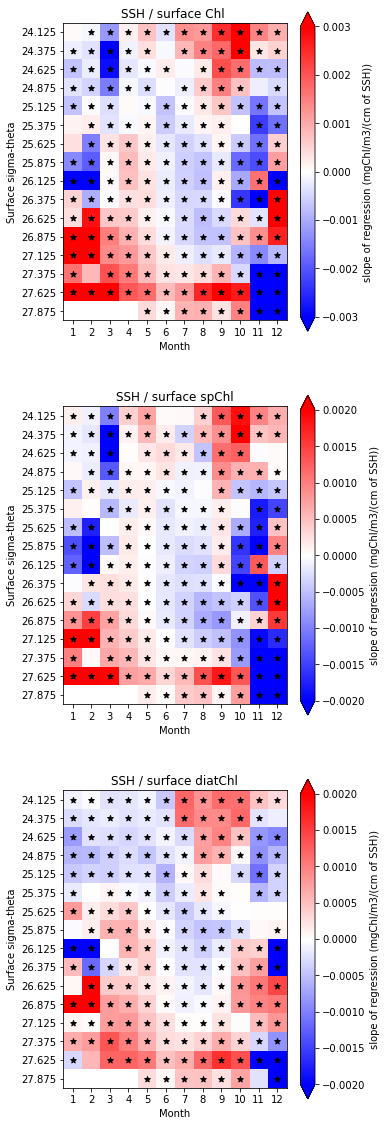

In [17]:
fig = plt.figure(figsize=(5,20))

ax = fig.add_subplot(3,1,1)

ax.set_title('SSH / surface Chl ')
pc=ax.imshow(ds_m_vals['totChl_surf'].values,cmap='bwr',vmin=-0.003,vmax=0.003)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.totChl_surf[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (mgChl/m3/(cm of SSH))')

ax = fig.add_subplot(3,1,2)

ax.set_title('SSH / surface spChl')
pc=ax.imshow(ds_m_vals['spChl'].values,cmap='bwr',vmin=-0.002,vmax=0.002)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.spChl[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (mgChl/m3/(cm of SSH))')

ax = fig.add_subplot(3,1,3)

ax.set_title('SSH / surface diatChl')
pc=ax.imshow(ds_m_vals['diatChl'].values,cmap='bwr',vmin=-0.002,vmax=0.002)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.diatChl[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (mgChl/m3/(cm of SSH))')

# ax = fig.add_subplot(4,1,4)

# ax.set_title('SSH / surface diazChl')
# pc=ax.imshow(ds_m_vals['diazChl'].values,cmap='bwr',vmin=-0.0001,vmax=0.0001)
# for i in range(len(ds_r_vals.sigma_reg)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.diazChl[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")
# ax.set_xticks(np.arange(len(ds_r_vals.month)))
# ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# # ... and label them with the respective list entries
# ax.set_xticklabels(ds_r_vals.month.values)
# ax.set_yticklabels(ds_r_vals.sigma_reg.values)
# ax.set_ylabel('SSH (cm)')
# ax.set_xlabel('Month')
# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (mgChl/m3/(cm of SSH))');

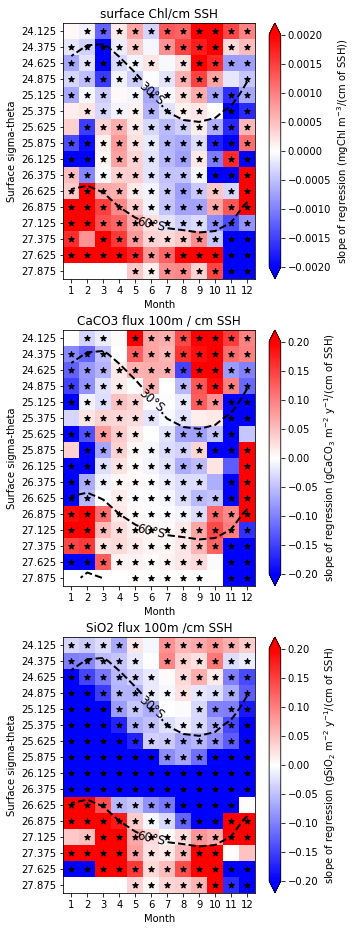

In [10]:
fig = plt.figure(figsize=(5,16))

ax = fig.add_subplot(3,1,1)

ax.set_title('surface Chl/cm SSH')
pc=ax.imshow(ds_m_vals['totChl_surf'].values,cmap='bwr',vmax=0.002,vmin=-0.002)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.totChl_surf[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")

################## add contour lines of latitude/SSH
fmt = ['60°S','30°S']
levels=[-60,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)

# levels=[-160.,-100.,-60,-20.,0.,20.,30]
# cs=ax.contour(ds_lat_ssh['SSH'].values,levels, colors='green')
# plt.clabel(cs, colors = 'green', fmt = '%2.1f', fontsize=12)
###################
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (mgChl m$^{-3}$/(cm of SSH))')



ax = fig.add_subplot(3,1,2)

ax.set_title('CaCO3 flux 100m / cm SSH')
pc=ax.imshow(ds_m_vals['CaCO3_FLUX_IN'].values,cmap='bwr',vmax=0.2,vmin=-0.2)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.CaCO3_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
################## add contour lines of latitude/SSH
levels=[-70.,-60.,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['70°S','60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)
#####################
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (gCaCO$_3$ m$^{-2}$ y$^{-1}$/(cm of SSH)')

ax = fig.add_subplot(3,1,3)

ax.set_title('SiO2 flux 100m /cm SSH')
pc=ax.imshow(ds_m_vals['SiO2_FLUX_IN'].values,cmap='bwr',vmax=0.2,vmin=-0.2)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.SiO2_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
################## add contour lines of latitude/SSH
levels=[-60,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k',linewidths = 2)
fmt = {}
strs = ['60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'k', fmt = fmt, fontsize=12)
#####################
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='slope of regression (gSiO$_2$ m$^{-2}$ y$^{-1}$/(cm of SSH)');

fig.savefig('/glade/u/home/kristenk/besome/hi-res-analysis/figs/hovmoeller_slopes_chl_fluxes_sigma.png', bbox_inches='tight', format='png', dpi=600);

In [26]:
outfile='/glade/u/home/kristenk/besome/hi-res-analysis/nc_out/lat_ssh_means_sigmareg.nc'
ds_lat_ssh=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

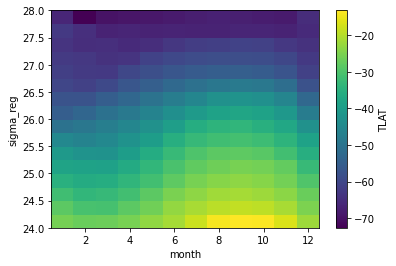

In [28]:
ds_lat_ssh.TLAT.plot()

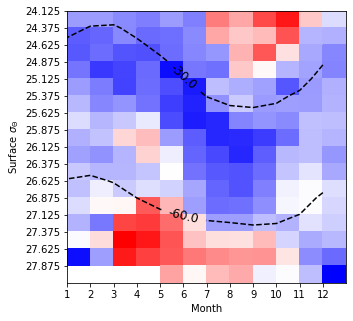

In [21]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()
#ax.set_title('surface Chl/cm SSH')
pc=ax.pcolormesh(ds_r_vals['diatC'].values,cmap='bwr')
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface ${\sigma}_{\Theta}$')
ax.set_xlabel('Month')
levels=[-60,-30.]

cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='k')
plt.clabel(cs, colors = 'k', fmt = '%2.1f', fontsize=12);

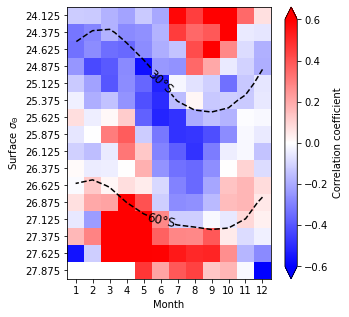

In [29]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

#ax.set_title('SSH / surface Chl')
pc=ax.imshow(ds_r_vals['diatC'].values,cmap='bwr',vmax=-0.6,vmin=0.6)
# for i in range(len(ds_r_vals.sigma_reg)):
#     for j in range(len(ds_r_vals.month)):
#         if ds_p_vals.totChl_surf[i,j].values< 0.05:
#             ax.scatter(j, i,
#                        color="black", marker="*")
            
#add contour lines of latitude
levels=[-60,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='black')
fmt = {}
strs = ['60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'black', fmt = fmt, fontsize=12)

# levels=[-80.,-60,-20.,20.,40]
# cs=ax.contour(ds_lat_ssh['SSH'].values,levels, colors='green')
# plt.clabel(cs, colors = 'green', fmt = '%2.1f', fontsize=12)

ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface ${\sigma}_{\Theta}$')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Correlation coefficient')
fig.savefig('/glade/u/home/kristenk/proposal_figs/CHAP2021/hovmoeller_slopes_diatC_sigma.png', bbox_inches='tight', format='png', dpi=300);

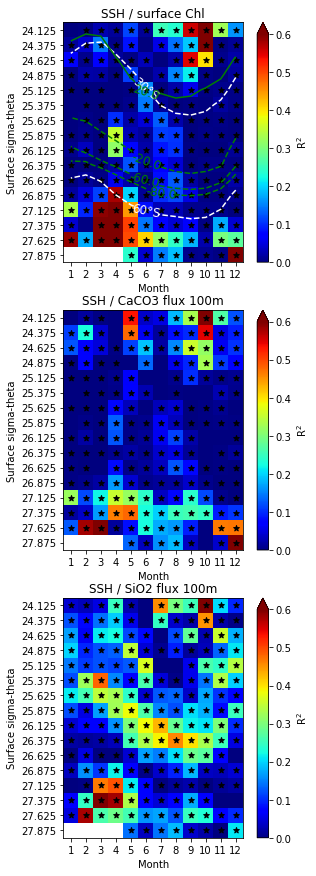

In [77]:
fig = plt.figure(figsize=(5,15))

ax = fig.add_subplot(3,1,1)

ax.set_title('SSH / surface Chl')
pc=ax.imshow(ds_r_vals['totChl_surf'].values**2,cmap='jet',vmax=0,vmin=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.totChl_surf[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
            
#add contour lines of latitude
levels=[-60,-30.]
cs=ax.contour(ds_lat_ssh['TLAT'].values,levels, colors='white')
fmt = {}
strs = ['60°S','30°S']
for l, s in zip(cs.levels, strs):
    fmt[l] = s
plt.clabel(cs, colors = 'white', fmt = fmt, fontsize=12)

levels=[-80.,-60,-20.,20.,40]
cs=ax.contour(ds_lat_ssh['SSH'].values,levels, colors='green')
plt.clabel(cs, colors = 'green', fmt = '%2.1f', fontsize=12)

ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='R$^2$')

ax = fig.add_subplot(3,1,2)

ax.set_title('SSH / CaCO3 flux 100m')
pc=ax.imshow(ds_r_vals['CaCO3_FLUX_IN'].values**2,cmap='jet',vmax=0,vmin=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.CaCO3_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='R$^2$')

ax = fig.add_subplot(3,1,3)

ax.set_title('SSH / SiO2 flux 100m')
pc=ax.imshow(ds_r_vals['SiO2_FLUX_IN'].values**2,cmap='jet',vmax=0,vmin=0.6)
for i in range(len(ds_r_vals.sigma_reg)):
    for j in range(len(ds_r_vals.month)):
        if ds_p_vals.SiO2_FLUX_IN[i,j].values< 0.05:
            ax.scatter(j, i,
                       color="black", marker="*")
ax.set_xticks(np.arange(len(ds_r_vals.month)))
ax.set_yticks(np.arange(len(ds_r_vals.sigma_reg)))
# ... and label them with the respective list entries
ax.set_xticklabels(ds_r_vals.month.values)
ax.set_yticklabels(ds_r_vals.sigma_reg.values)
ax.set_ylabel('Surface sigma-theta')
ax.set_xlabel('Month')
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='R$^2$');